#### This notebook fits an Recurring Neural Network over Headlines dataset for sarcasm detection.

In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import hstack
from normalizer import Normalizer
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout

tf.device = tf.device("gpu")

First let's set our envoringment to GPU!

Load the dataset:

In [2]:
data = pd.read_json("../dataset/Sarcasm_Headlines_Dataset.json", lines = True)

Explore the data:

In [3]:
data.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26709 entries, 0 to 26708
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   article_link  26709 non-null  object
 1   headline      26709 non-null  object
 2   is_sarcastic  26709 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 626.1+ KB


Check if the datatset is balanced?

In [5]:
len(data.loc[data["is_sarcastic"]==0])

14985

In [6]:
len(data.loc[data["is_sarcastic"]==1])

11724

The dataset is unbalanced let's balance it!

In [7]:
sarcastic_data = data.loc[data["is_sarcastic"]==1]
nonsarcastic_data = data.loc[data["is_sarcastic"]==0][:11724]

data = pd.concat([sarcastic_data, nonsarcastic_data])
data.head(5)

,article_link,headline,is_sarcastic
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
15,https://entertainment.theonion.com/nuclear-bom...,nuclear bomb detonates during rehearsal for 's...,1
16,https://www.theonion.com/cosby-lawyer-asks-why...,cosby lawyer asks why accusers didn't come for...,1


Now the dataset is balanced.

In [8]:
data = data.drop(columns=["article_link"])

Seperate the labels from the text.

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23448 entries, 2 to 20970
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   headline      23448 non-null  object
 1   is_sarcastic  23448 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 549.6+ KB


In [10]:
X = data["headline"]
y = data["is_sarcastic"]

Now using the Normalization package that we created before, let's vectorize the text:

In [11]:
X_matrix = Normalizer().vectorize(data)


[INFO] Trying to create a sparse matrix for text, using an instance of TfIdf_vectorizer
[INFO] Extracting columns containing text from dataframe.
[INFO] Successfully extracted text columns from the dataset.
[INFO] Applying Normalization over text:
[INFO]       - Converting Text into lower case for caseconsistency.
[INFO]       - Extracting only words containing alphabets.
[INFO] Text Normalization is now complete.
[INFO] Fitting the vecotirzer to given text.
[INFO] Transforming the text into a sparse matrix.
[INFO] Sparse Matrix has been successfully created over the text given as input.


Let's split the set into validation and train set:

In [12]:
X_train, X_Test, y_train, y_test = train_test_split(X_matrix, y, test_size=0.33, random_state=42)

Now that we have the necessary datasets ready let's fit an RNN to it.

In [14]:
rnn = keras.Sequential([
    keras.layers.LSTM(32, activation='relu', input_shape=(X_train.shape[1], 1)),
    Dropout(0.5),
    keras.layers.LSTM(16, activation='relu'),
    Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])


# Compile the RNN model
rnn.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])


ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)

In [ ]:
history = rnn.fit(X_train.toarray(), y_train, epochs=50, batch_size=256, validation_data=(X_Test.toarray(), y_test))


Epoch 1/650


ValueError: in user code:

    File "c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Sanju\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_9" is incompatible with the layer: expected shape=(None, 15710, 24327), found shape=(None, 24327)


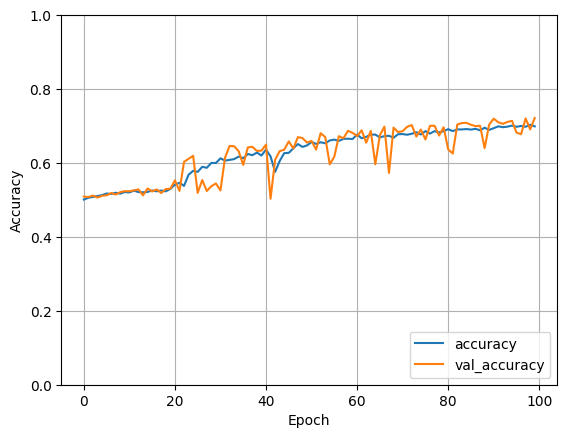

In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.grid()
plt.show()